In [197]:
import json
import re
from typing import Union, Any

import joblib
import lightgbm as lgb
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
from dirty_cat import MinHashEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    mean_absolute_error,
    precision_score,
    recall_score,
    r2_score
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
)
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import dill


# Игнорировать все предупреждения
import warnings
warnings.filterwarnings('ignore')

### Описание датасета

Данный датасет представляет собой набор данных для предсказания цены на квартиру. В данных присутствует большое количество аномалий, неправильного ввода значений и шума, над которыми предстоит поработать.

#### Описание данных:
- **'status'** — статус продажи;
- **'private pool'** и **'PrivatePool'** — наличие собственного бассейна;
- **'propertyType'** — тип объекта недвижимости;
- **'street'** — адрес объекта;
- **'baths'** — количество ванных комнат;
- **'homeFacts'** — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
- **'fireplace'** — наличие камина;
- **'city'** — город;
- **'schools'** — сведения о школах в районе;
- **'sqft'** — площадь в футах;
- **'zipcode'** — почтовый индекс;
- **'beds'** — количество спален;
- **'state'** — штат;
- **'stories'** — количество этажей;
- **'mls-id'** и **'MlsId'** — идентификатор MLS (Multiple Listing Service, система мультилистинга);
- **'target'** — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

### Этапы работы с датасетом

1. **Предварительный анализ данных**
   - Анализ структуры данных и типов признаков.
   - Поиск и устранение пропусков в данных.
   - Идентификация аномалий и исправление ошибок ввода.

2. **Предобработка данных**
   - Обработка категориальных признаков (например, кодирование).
   - Очистка и исправление текстовых данных (например, адресов и идентификаторов).

3. **Обработка аномалий и выбросов**
   - Выявление и корректировка выбросов.
   - Замена или удаление аномальных значений.

4. **Построение и обучение моделей**
   - Выбор и настройка моделей для предсказания цены (например, линейная регрессия, деревья решений, градиентный бустинг).
   - Проведение кросс-валидации для оценки производительности моделей.
   - Оптимизация гиперпараметров.

5. **Оценка моделей**
   - Оценка точности предсказаний с использованием метрик (например, MAE, R²).
   - Сравнение производительности различных моделей.

6. **Интерпретация и выводы**
   - Интерпретация результатов и выводы по точности предсказаний.
   - Рекомендации по возможным улучшениям и будущим шагам.

Этот план действий поможет организовать работу с данными и обеспечить качественную подготовку и анализ для построения точной модели предсказания цен на квартиры.


# Предварительный анализ и предобработка данных


In [198]:
#%%script false
main_data = pd.read_csv('data/data.csv', sep = ',')

In [199]:
data = main_data.copy()
data.shape

(377185, 18)

#### Вспомогательные функции для сокращения времени

In [200]:

def Hist(data: pd.DataFrame, col: str) -> None:
    """
    Строит гистограмму распределения значений столбца 'col' из DataFrame 'data'.
    Использует 100 интервалов.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(data[col], bins=100, kde=False, color='blue')
    
    plt.title('Гистограмма распределения площади квартиры', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    
    # Центрирование заголовка
    plt.gca().title.set_position([0.5, 1.05])
    
    plt.tight_layout()
    plt.show()

def Box(data: pd.DataFrame, col: str) -> None:
    """
    Строит коробчатую диаграмму для значений столбца 'col'.
    Показывает распределение и выбросы.
    """
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[col], color='orange')
    
    plt.title("Коробчатая диаграмма значений по категориям", fontsize=16)
    plt.xlabel(col, fontsize=14)
    
    # Центрирование заголовка
    plt.gca().title.set_position([0.5, 1.05])
    
    plt.tight_layout()
    plt.show()

def Heat(data: pd.DataFrame, col: str) -> None:
    """
    Строит тепловую карту корреляции столбца 'col' с остальными числовыми столбцами.
    Удаляет пустые значения перед построением.
    """
    data.reset_index(drop=True, inplace=True)

    df = data.select_dtypes(include=['number', 'bool'])
    df = df.dropna()

    correlation_baths = df.corr()[col]
    correlation_df = correlation_baths.reset_index()
    correlation_df.columns = ['Feature', 'Correlation']

    fig = px.imshow(
        correlation_df.set_index('Feature').T,  
        labels=dict(x='Feature', y='Correlation'),
        title='Correlation with {col}'
        )

    fig.show()


def find_missing_and_object_columns(df: pd.DataFrame = data) -> None:
    """
    Функция для вывода признаков, в которых есть пропущенные значения, или их тип является object
    """
    missing_data = pd.DataFrame({
        'Missing Values': df.isnull().sum(),
        'data Type': df.dtypes
    })

    filtered_missing_data = missing_data[
        (missing_data['data Type'] == 'object') | (missing_data['Missing Values'] > 0)
    ]

    #filtered_missing_data = filtered_missing_data.sort_values(by='Missing Values', ascending=False)
    print(filtered_missing_data.sort_values(by='Missing Values', ascending=False))

#### Удалим признаки которые никак не влияют на целевую переменную, так же удалим пропуски в целевой признаке

In [201]:
data.drop(['MlsId', 'mls-id'], axis=1, inplace=True)
data.drop_duplicates(inplace=True)
data.dropna(subset=['target', 'street', 'city'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [202]:
data['PrivatePool'] = data['private pool'].combine_first(data['PrivatePool'])
data.drop('private pool', axis=1, inplace=True)
data['PrivatePool'] = data['PrivatePool'].map({'yes': True, 'Yes': True}).fillna(False).astype(bool)

In [203]:
def extract_number(value: str) -> int:
    value = value.lower()
    tedatat_to_number = {
        'one': 1, 'two': 2, 'three': 3, 'four': 4,
        'five': 5, 'six': 6, 'seven': 7, 'eight': 8,
        'nine': 9, 'ten': 10, 'eleven': 11, 'twelve': 12
    }

    for word, num in tedatat_to_number.items():
        if word in value:
            return num
        
    match = re.search(r'(\d+)(?=\+)?', value)
    if match:
        return int(match.group(1))
    elif 'yes' in value:    
        return 1
    else:
        return np.nan
    
def count_rooms(value: str) -> int:
    room_types = ['Family', 'Bedroom', 'Living', 'Den', 'Kitchen', 'Dining', 'FAMILYRM',
                  'Library', 'Study', 'Playroom', 'Recreation', 'Sitting', 'Guest', 'Office']
    
    count = sum(value.count(room) for room in room_types)
    return count if count > 0 else 1

def handle_missing(value: str) -> int:
    if isinstance(value, str) and value in ['N/K', 'No', 'Not Applicable', 'None', 'Non-Functional', 'Inoperative', 'Edatatra Closets']:
        return 0
    

def identify_fireplace_type(value: str) -> int:
    if isinstance(value, str):
        value = value.lower()
        if 'gas' in value:
            return 1
        if 'wood' in value or 'burning' in value:
            return 2
        if 'electric' in value:
            return 3
        
    return 0


data['count_fireplace'] = data['fireplace'].apply(lambda data: handle_missing(data) if isinstance(data, str) else np.nan)
data['count_fireplace'] = data['count_fireplace'].fillna(data['fireplace'].apply(lambda data: extract_number(data) if isinstance(data, str) else np.nan))
data['count_fireplace'] = data['count_fireplace'].fillna(data['fireplace'].apply(lambda data: count_rooms(data) if isinstance(data, str) else np.nan))
data['count_fireplace'] = data['count_fireplace'].fillna(0)
data['fireplace_type'] = data['fireplace'].apply(identify_fireplace_type)

data.drop('fireplace', axis=1, inplace=True)

In [204]:
print(set(data['status'].unique().tolist()))

{'Coming soon: Dec 11.', 'Foreclosure', 'Contingent Finance And Inspection', 'Pending With Contingencies', 'Pending Offer Approval', 'Coming soon: Dec 20.', 'Accepted Offer', 'Pending W/ Cont.', 'Coming soon: Dec 15.', 'Contract', 'Under Contract Show', 'Coming soon: Dec 25.', 'Active With Offer', 'Under contract', 'P Pending Sale', 'Coming soon: Dec 9.', 'Contingent', 'Due Diligence Period', 'Contingent Finance and Inspection', 'Contingent   Release', 'Apartment for rent', 'Pending, Continue to Show', 'pending', 'Coming soon: Dec 12.', 'Pending   Continue To Show   Financing', ' / auction', 'Option Pending', 'Coming soon: Oct 29.', 'Coming soon: Dec 14.', 'Active Under Contract', 'Auction', 'Pending   Continue To Show', 'Coming soon: Dec 4.', 'Coming soon: Dec 6.', 'Coming soon: Oct 30.', 'P', 'Coming soon: Nov 5.', 'Contingent   Show', 'Under Contract W/ Bckp', 'Coming soon: Nov 27.', 'Pending Continue To Show', 'Coming soon: Dec 23.', 'Pending Take Backups', 'Under Contract', 'Comin

#### Важные признаки для статуса сделки

Наибольший интерес представляют значения, где указано, что недвижимость сдаётся в аренду.  
Также можно выделить три основных признака, отвечающих за статус сделки:

1. **For Sale/Active** — активно продаётся.
2. **Pending/Under Contract** — в стадии рассмотрения.
3. **Foreclosure/Auction** — изъятое имущество.


In [205]:
def status_to_number(value: str) -> int:
    if pd.isna(value):
        return 0
    
    value = value.lower()
    for index, (_, statuses) in enumerate(status_groups.items()):
        statuses_lower = [status.lower() for status in statuses]
        
        if value in statuses_lower:
            return index + 1
    
    return -999  # Возвращаем -999, если статус не найден


status_groups = {
            'For Sale/Active': [
                'for sale', 'active', 'new construction', 'new', 'active under contract', 
                'active with offer', 'active/contingent', 'active - auction', 'active with contract', 
                'auction active', 'auction', 'back on market', 'listing extended', 'active option', 
                'price change', 'a active', 'temporary active'
            ],
            'Pending/Under Contract': [
                'pending', 'under contract', 'contingent', 'pending continue to show', 'p',
                'option pending', 'pending taking backups', 'under contract show', 'under contract showing', 
                'under contract backups', 'pending backup wanted', 'pending take backups', 
                'pending continue show', 'pending inspection', 'due diligence period', 'p pending sale',
                'active with contingencies', 'pending ab', 'contingent finance and inspection',
                'contingent show', 'contingent take backup', 'pf', 'under contract showing', 
                'c', 'ct', 'pending - continue to show', 'pending (do not show)',
                'pending - backup offer requested', 'pending w/backup wanted', 'option contract',
                'pending - taking backups', 'offer pending signature', 'pending fe',
                'pending w/insp finance', 'uc continue to show', 'contingency contract',
                'under contract - show', 'pending offer approval', 'contingent escape',
                'pending with contingencies', 'contingent - financing', 'contract contingent on buyer sale',
                'pending, continue to show', 'pending bring backup', 'pending w/ escape clause',
                'pending - continue to show', 'pending sh', 'pending w/ cont.', 
                'pending continue to show   financing', 'pending inspection', 
                'under contract taking back up offers', 'backup contract', 'backup',
                'contract p', 'contingency 48 hr (+/ )', 'conting accpt backups',
                'contingent release', 'contingent lien holder release', 'contingent - sale of home',
                'pending sale', 'pending - continue to show', 'contingent foreclosure','under contract   showing'
            ],
            'Foreclosure/Auction': [
                'foreclosure', 'pre-foreclosure', 'foreclosed', 'auction', 'pre-foreclosure / auction', 
                'auction - active', ' / auction', 'pending auction', 'auction - active', 'foreclosure auction'
            ],
        }


data['for_rent'] = data['status'].apply(
    lambda x: 'rent' in str(x).lower() or 'purchase' in str(x).lower())
data['status'] = data['status'].apply(status_to_number)


In [206]:
word_to_num={
        "one half":0.5, "one": 1, "two": 2, "three": 3, "four": 4, 
        "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9, "ten": 10,
        "duplex":2, "ground":1, "triplex":3, 'tri':3
    }

def process_stories(story: str) -> int:
    """Обрабатывает строку с количеством этажей, заменяет текстовые обозначения на числа и возвращает среднее количество этажей или NaN."""
    if pd.isna(story):
        return np.nan  
    
    stories = 0
    story = story.lower()
   
    for word, num in word_to_num.items():
        story = story.replace(word, str(num))
   
    numbers = re.findall(r'\d+\.?\d*', story)
    if numbers:
        stories += sum([float(num) for num in numbers]) / len(numbers)
    
    story = story.replace('-', ' ')
    if "basement" in story or "tri level" in story:
        stories += 0.5
    
    return stories if stories > 0 else np.nan


data['stories'] = data['stories'].apply(process_stories)

##### С **propertyType** поступим интереснее, проведём "чистку" данного призанка, после чего применим `MinHashEncoder` для преобразования этого признака в хеш строку

In [207]:
def clean_property_type(pt: str) -> str:
    """Очищает строку, представляющую тип недвижимости, удаляя дублирующиеся и ненужные символы."""
    if pd.isna(pt):
        return 'missing'  
    
    pt = re.sub(r'\b(\w+)(_\1\b)+', r'\1', pt)
    pt = re.sub(r'\b(\w+)(/\1\b)+', r'\1', pt)

    pt = re.sub(r'\s+/|/\s+', '/', pt)
    pt = re.sub(r'\s+', '_', pt)
    pt = re.sub(r'(_{2,})', '_', pt)
    pt = re.sub(r'(_home)+', '_home', pt)
    pt = re.sub(r'(_story)+', '_story', pt)

    pt = re.sub(r'\bhome_home\b', 'home', pt)
    
    return pt


replacements = {
            r'single[\s_-]*family[\s_-]*home|single[\s_-]*family[\s_-]*': 'single_family_home',
            r'condo|condo/townhome.*|coop.*': 'condo',
            r'townhouse|row home|townhome': 'townhouse',
            r'multi[\s_-]*family': 'multi_family_home',
            r'lot/land|land|farms/ranches': 'land',
            r'mobile': 'mobile_home',
            r'apartment': 'apartment',
            r'ranch': 'ranch',
            r'contemporary|modern|contemporary/modern': 'contemporary_modern',
            r'colonial': 'colonial',
            r'traditional': 'traditional',
            r'1 story|one story': 'one_story',
            r'2 stories|two story': 'two_story',
            r'other': 'other'
            }


data['propertyType'] = data['propertyType'].str.lower().str.strip()
data['propertyType'] = data['propertyType'].apply(clean_property_type)

# Применение замен
for pattern, replacement in replacements.items():
    data['propertyType'] = data['propertyType'].replace(to_replace=pattern, value=replacement, regex=True)

cat_type_encoder = MinHashEncoder()
data['propertyType'] = cat_type_encoder.fit_transform(data[['propertyType']])



##### В колонке **homeFacts** хранится json строка с большим количествов признаков, проведём небольшую чистку, после чего добавим эти значения в наш датасет

In [208]:
columns = ['Cooling', 'Heating', 'Parking', 'Price/sqft', 'Remodeled year', 'Year built', 'lotsize']

def extract_home_features(home_facts_str: str) -> dict:
    """Извлекает характеристики дома из строки JSON и возвращает словарь с данными."""
    if pd.isna(home_facts_str):
        return {col: np.nan for col in columns}
    
    try:
        home_facts_str = home_facts_str.replace("'", '"')
        home_facts_str = home_facts_str.replace('"closet"-Electric', 'closet-Electric')

        home_facts_str = re.sub(r'(?<!")\bNone\b(?!")', '"None"', home_facts_str)
        home_facts_str = re.sub(r'(?<=[a-z-A-Z])"(?=[a-zA-Z])', '/', home_facts_str)

        home_facts_dict = json.loads(home_facts_str)

        facts = home_facts_dict.get('atAGlanceFacts', [])
        features = {fact['factLabel']: fact['factValue'] for fact in facts}

        return {col: features.get(col, np.nan) for col in columns}
    
    except json.JSONDecodeError as e:
        print("Ошибка декодирования JSON:")
        print(f"Сообщение об ошибке: {e}")
        print(f"Проблемная строка JSON: {home_facts_str}")
        return {col: np.nan for col in columns}


if 'homeFacts' not in data.columns:
        raise ValueError("DataFrame must contain 'homeFacts' column")

    
new_columns = data['homeFacts'].apply(extract_home_features)
new_df = pd.DataFrame(new_columns.tolist())

data.drop('homeFacts', inplace=True, axis=1)
data = data.join(new_df)


Ошибка декодирования JSON:
Сообщение об ошибке: Expecting ',' delimiter: line 1 column 249 (char 248)
Проблемная строка JSON: {"atAGlanceFacts": [{"factValue": "1960", "factLabel": "Year built"}, {"factValue": "", "factLabel": "Remodeled year"}, {"factValue": "Forced Air", "factLabel": "Heating"}, {"factValue": "Central", "factLabel": "Cooling"}, {"factValue": "Carport, "None", Attached Garage", "factLabel": "Parking"}, {"factValue": "5,000 sqft", "factLabel": "lotsize"}, {"factValue": "$500/sqft", "factLabel": "Price/sqft"}]}


##### В колонке **schools** похожий принцип что и в **homeFacts**, однако из всех данных нас тут интересует только рейтинг школ в округе недвижимости

In [209]:
def extract_school_features(school_facts_str: str) -> dict:
    """Извлекает характеристики школ из строки JSON и возвращает словарь с данными."""
    if pd.isna(school_facts_str):
        return {
            'Average Rating': np.nan, 
        }
    
    try:
        school_facts_str = school_facts_str.replace("'", '"')
        school_facts_str = re.sub(r'(?<!")\bNone\b(?!")', '"None"', school_facts_str)
        school_facts_str = re.sub(r'NR', 'None', school_facts_str)
        school_facts_str = re.sub(r'NA', 'None', school_facts_str)
        school_facts_str = re.sub(r'(?<=[a-z-A-Z])"(?=[a-zA-Z])', '/', school_facts_str)
        school_facts_str = re.sub(r', "name": \[[^\]]*\]', '', school_facts_str)

        features = json.loads(school_facts_str)[0]

        try: 
            ratings = []
            for rating in features['rating']:
                if 'None' not in rating:
                    rating_value = rating.split('/')[0]  
                    ratings.append(int(rating_value))
        except:
            ratings=[]

        return {
            'Average Rating': np.mean(ratings) if ratings else np.nan,
        }
    
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError: {e}")
        print(f'Problematic string: {school_facts_str}')
        return {
            'Average Rating': np.nan, 
        }
    
    except Exception as err: 
        print(err)


columns= ['Average Rating']

# Применение функции для извлечения признаков
data.reset_index(drop=True, inplace=True)
new_columns = data['schools'].apply(extract_school_features)
new_df = pd.DataFrame(new_columns.tolist(), columns=columns)

data.drop('schools', inplace=True, axis=1)
data = data.join(new_df)


##### Также можно заметить, что из-за человеческого фактора в колонки **baths** и **beds** часто попадают значения, предназначенные для признака **sqft**. Давайте исправим эту ситуацию.


In [210]:
def extract_sqft(text: str) -> float:
    """Функция ищет и возвращает число, предшествующее подстроке 'sqft'"""
    if pd.isna(text):
        return np.nan
    
    #text = str(text).replace(',', '') 
    match = re.search(r'(\d+)\s?sqft', str(text).replace(',', '') ) 
    if match:
        return float(match.group(1)) 
    return np.nan


def fill_sqft_from_columns(X: pd.DataFrame, cols_to_check: list[str]) -> pd.DataFrame:
    for col in cols_to_check:
        # Ищем информацию о площади в каждом указанном столбце data
        X['sqft'] = X.apply(
            lambda row: extract_sqft(row[col]) if pd.isna(row['sqft']) else row['sqft'], 
            axis=1
        )

    return X


miss_sqft_before = data['sqft'].isna().sum()

cols_to_check = ['baths', 'beds']
data = fill_sqft_from_columns(data, cols_to_check)

miss_sqft_after = data['sqft'].isna().sum()


print(f'Пропуски в sqft до применения: {miss_sqft_before}')
print(f'Пропуски в sqft после применения: {miss_sqft_after}')

Пропуски в sqft до применения: 40080
Пропуски в sqft после применения: 38824


In [211]:
def give_number(pt: str) -> float:
    """Извлекает число из строки, заменяет запятые и возвращает его в виде float."""
    
    if pd.isna(pt):
        return np.nan
    
    pt = str(pt).replace(',', '')
    if not pt:
        return np.nan

    match = re.search(r'\d+\.?\d*', str(pt)) 
    if re.search(r'\d+\.?\d*', str(pt)) :
        return float(match.group())  
    else:
        return np.nan


columns = ['baths','sqft', 'beds', 'target', 'lotsize','Year built','Remodeled year']

for col in columns:
    if col not in data.columns:
        raise ValueError(f"DataFrame must contain column '{col}'")
    else:
        data[col] = data[col].apply(give_number)
        

In [212]:
def extract_number_second(value: str) -> int:
    """Извлекает количество парковочных мест из строки или возвращает 0 для отсутствующих данных."""
    
    if pd.isna(value):
            return np.nan  
    
    value = value.strip().lower()
    if 'no data' in value or 'no parking' in value:
        return 0
   
    match = re.search(r'\b(\d+)\s*spaces?\b', value)
    if match:
        return int(match.group(1))
   
    match = re.search(r'\b(\d+)\b', value)
    if match:
        return int(match.group(1))
    
    return None


data['Parking'] = data['Parking'].apply(extract_number_second)
data['Parking'] = data['Parking'].fillna(0)
data['Price/sqft'] = data['Price/sqft'].apply(extract_number_second).astype(float)

##### С признаками **Cooling** и **Heating** поступим похожим образом как и с **propetyType**, однако перед эти немного сгрупируем данные

In [213]:
def process_cooling(cooling: str) -> str:
    """Классифицирует типы охлаждения на основе строки описания."""
    
    cooling_patterns = {
            r'central|zoned': 'Central A/C',
            r'window|wall': 'Window/Wall Unit',
            r'heat pump': 'Heat Pump',
            r'no a/c|no cooling': 'No A/C',
            r'fan': 'Fan',
            r'geothermal': 'Geothermal',
            r'evaporative': 'Evaporative Cooler',
            r'solar': 'Solar A/C'
        }
    
    if pd.isna(cooling):
            return np.nan  
    
    for pattern, category in cooling_patterns.items():
        if re.search(pattern, cooling, re.IGNORECASE):  # re.IGNORECASE делает поиск нечувствительным к регистру
            return category
        
    return 'Other'


data['Cooling_Categorized'] = data['Cooling'].apply(process_cooling)
data['Cooling_Categorized'] = data['Cooling_Categorized'].fillna(data['Cooling_Categorized'].mode()[0])


encoder = MinHashEncoder(n_components=3)
encoded = encoder.fit_transform(data[['Cooling_Categorized']])
encoded_df = pd.DataFrame(encoded, columns=[f'Cooling_{i}' for i in range(encoded.shape[1])])


data.reset_index(drop=True, inplace=True)
data = pd.concat([data, encoded_df], axis=1)
data.drop(['Cooling','Cooling_Categorized'], axis=1, inplace=True)

In [214]:
def categorize_heating(heating: str) -> str:
    """Классифицирует тип отопления на основе строки описания."""
    
    heating_patterns = {
           'gas|natural gas|propane': 'Gas',
           'electric|electricity': 'Electric',
           'heat pump': 'Heat Pump',
           'stove|wood|pellet': 'Stove',
           'radiant|radiator': 'Radiant',
           'central': 'Central',
           'solar': 'Solar',
           'fireplace': 'Fireplace',
           'baseboard': 'Baseboard',
           'steam': 'Steam',
           'wall': 'Wall',
           'forced air': 'Forced Air'
       }
    
    if pd.isna(heating):
            return np.nan  

    for pattern, heating_type in heating_patterns.items():
        if re.search(pattern, heating, re.IGNORECASE):
            return heating_type

    return 'Other'


data['Heating_Categorized'] = data['Heating'].apply(categorize_heating)

encoder = MinHashEncoder(n_components=2)  
encoded = encoder.fit_transform(data[['Heating_Categorized']])
encoded_df = pd.DataFrame(encoded, columns=[f'Heating_{i}' for i in range(encoded.shape[1])])

# Объединение закодированных столбцов с исходным DataFrame
data.reset_index(drop=True, inplace=True)
data = pd.concat([data, encoded_df], axis=1)
data.drop(['Heating','Heating_Categorized'], axis=1, inplace=True)

##### С оставшимися **категориальными** значениями поступим просто: создадим на их основе хеш строки. Однако сами столбцы оставим для дальнейшей визуализации и получения геоданных.


In [215]:
def minhash_transform(X: pd.DataFrame) -> pd.DataFrame:
    """Применяет MinHash кодирование к DataFrame и возвращает закодированный DataFrame."""
    encoder = MinHashEncoder(n_components=2)  
    encoded = encoder.fit_transform(X.values.reshape(-1, 1))

    encoded_df = pd.DataFrame(encoded, columns=[f'{col}_{i}' for i in range(encoded.shape[1])])
    return encoded_df


data.reset_index(drop=True, inplace=True)
cols = ['city', 'street', 'state']

for col in cols:
    transformed = minhash_transform(data[col])
    data = data.join(transformed)

# Обработка аномалий, выбросов, а так же устранение пропусков

##### Перед обработкой **Year built** проверим его диапазон 

In [216]:
data['Year built'].describe()

count    3.114050e+05
mean     3.598522e+06
std      1.419163e+09
min      1.000000e+00
25%      1.957000e+03
50%      1.985000e+03
75%      2.007000e+03
max      5.599906e+11
Name: Year built, dtype: float64

##### В данном признаке присутствуют явные выбросы, поэтому мы ограничим год постройки диапазоном от 1850 до 2024 года. Нижний порог выбран исходя из того, что более старые здания вряд ли будут актуальны на рынке.

##### Пропущенные значения заменим на **моду**, так как этот метод показал лучшие результаты по сравнению с использованием медианы или среднего. Мода равна **2019 году**, что позволит модели лучше соответствовать будущим данным и требованиям компании.



In [217]:
def transform_year(X: pd.DataFrame) -> pd.DataFrame:
    """Заполняет пропуски в 'Year built', фильтрует значения по диапазону и добавляет признаки 'is_remodeled' и 'property_age'."""
    
    year_mode = X['Year built'].mode()[0]
    X['Year built'] = X['Year built'].fillna(year_mode)

    X = X.loc[(X['Year built'] >= 1850) & (X['Year built'] <= 2024)].copy() #костыль для избежания ошибки SettingWithCopyWarning
    X.reset_index(drop = True, inplace = True)

    X['is_remodeled'] = (X['Remodeled year'] > X['Year built']).fillna(False).astype(bool)
    X['property_age'] = 2024 - X['Year built']
    
    X.drop(['Year built', 'Remodeled year'], axis=1, inplace=True)

    return X

data.reset_index(drop=True, inplace=True)
data = transform_year(data)

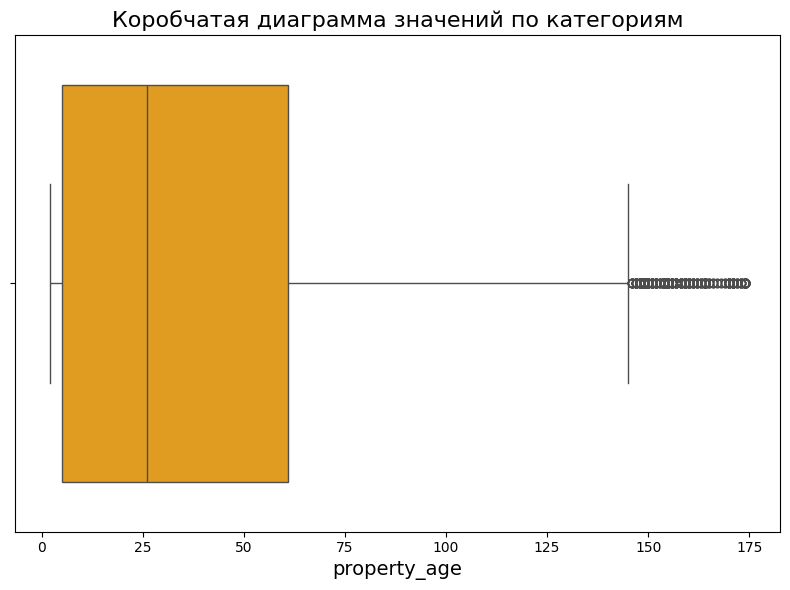

In [218]:
Box(data, 'property_age')

# 1.2 Заполнения пропущенных значений

In [219]:
find_missing_and_object_columns(data)

                Missing Values data Type
stories                 163276   float64
beds                    108099   float64
baths                   106707   float64
lotsize                  95261   float64
Price/sqft               62630   float64
sqft                     39627   float64
Average Rating            5068   float64
street                       0    object
city                         0    object
zipcode                      0    object
state                        0    object


Для заполнения данных я буду использовать модель типа **GBM**. Если модель сможет предсказывать значения с ошибкой, меньшей, чем при замене на среднее, это будет явным преимуществом по сравнению с простым заполнением средним или медианой.  

К тому же, одним из преимуществ моделей типа **GBM** является способность эффективно обрабатывать пропуски, что делает их идеальными для решения подобных задач.


In [220]:
def inplace_col(data: pd.DataFrame, features: list[str], target: str) -> pd.DataFrame:
    """Заполнение пропусков в данных с использованием моделей машинного обучения."""
    model = inplace_xgboost_model(data, features, target)
    baseline_model(data, features, target)
    data = fillna_optimized(data, model, features, target)
    return data

def baseline_model(data: pd.DataFrame, features: list[str], target: str) -> None:
    """Вычисляет и выводит ошибку базовой модели при использовании среднего значения"""
    data = data.dropna(subset=[target])
    X, y = data[features], data[target]
    

    baseline = DummyRegressor(strategy='mean')
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    mae_scores = cross_val_score(baseline, X, y, cv=kf, scoring='neg_mean_absolute_error')
    mae_mean = -mae_scores.mean()

    print(f"Baseline MAE (Mean Absolute Error): {mae_mean:.2f}", end='\n\n')


def inplace_xgboost_model(data: pd.DataFrame, columns: list[str], target: str) -> xgb.XGBRegressor:
    """Функция для оценки базовой модели на основе XGBoost с кросс-валидацией """
    df = data[columns + [target]].dropna(subset=[target]).reset_index(drop=True)
    X, y = df[columns], df[target]
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    param_grid = {
        'n_estimators': [100, 150,],     
        'learning_rate': [0.01, 0.1, 0.2], 
        'max_depth': [3, 5, 7],             
        'subsample': [0.8, 1.0],            
        'colsample_bytree': [0.8, 1.0]      
    }
    
    
    model = xgb.XGBRegressor(random_state=42)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    
   
    mae_scores = cross_val_score(best_model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(best_model, X, y, cv=kf, scoring='r2')
    
    
    mae_mean = -np.mean(mae_scores)
    r2_mean = np.mean(r2_scores)
    target_std = data[target].std()
    
    print(f'данные для {target}')
    print(f'Параметры модели: {print(grid_search.best_params_)}')
    print(f"MAE (Mean Absolute Error): {mae_mean:.2f}")
    print(f"R² Score: {r2_mean:.2f}")
    print(f"Standard deviation of {target}: {target_std:.2f}", end='\n\n')

    return best_model


def fillna_optimized(data: pd.DataFrame, model, features: list[str], target: str) -> pd.DataFrame:
    """Заполняет пропущенные значения в целевом столбце с использованием модели машинного обучения"""
    
    mask = data[target].isnull()
    features_to_predict = data.loc[mask, features]
    
    predicted = model.predict(features_to_predict)
    data.loc[mask, target] = predicted
    
    return data

In [221]:
def train_xgb_with_cv(df: pd.DataFrame, params: dict = None) -> None:
    """
    Функция для обучения модели XGBoost и оценки её производительности с помощью кросс-валидации.

    Эта функция выполняет следующие действия:
    1. Если параметры модели не переданы, выполняет случайный поиск гиперпараметров (RandomizedSearchCV) для модели XGBoost, чтобы найти лучшие гиперпараметры и оценить их с помощью MAE.
    2. Если параметры модели переданы, обучает модель XGBoost с указанными гиперпараметрами и оценивает её производительность с помощью кросс-валидации (KFold), используя MAE как метрику.
    
    Параметры:
    - df (pd.DataFrame): DataFrame с данными, содержащими как признаки, так и целевую переменную.
    - params (dict, optional): Словарь с гиперпараметрами для модели XGBoost. Если не указан, будет выполнен RandomizedSearchCV для поиска оптимальных гиперпараметров.

    Вывод:
    - Если параметры не переданы, функция выводит лучшие гиперпараметры и лучший MAE, достигнутый при помощи RandomizedSearchCV.
    - Если параметры переданы, функция выводит средний MAE, полученный при помощи кросс-валидации на обученной модели.
    """

    
    df = df.select_dtypes(include=['number', 'bool'])
    X = df.drop('target', axis=1)
    y = df['target']

    if not params:
        param_grid = {
            'n_estimators': [100, 200, 300, 500],
            'max_depth': [3, 5, 7, 10],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'gamma': [0, 0.1, 0.3, 0.5],
            'min_child_weight': [1, 3, 5]
        }
       
        model = xgb.XGBRegressor(random_state=42)
        random_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid, 
            n_iter=50,  
            scoring='neg_mean_absolute_error',  
            cv=5,  
            verbose=1, 
            random_state=42,
            n_jobs=-1 
        )

       
        random_search.fit(X, y)
        print("Лучшие параметры:", random_search.best_params_)
        print("Лучший MAE:", -random_search.best_score_)

    else:
        model = xgb.XGBRegressor(**params, random_state=42)
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        mae_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
        mae_mean = -mae_scores.mean()
        print(f"Средний MAE на KFold: {mae_mean}")

## 1.2.1 Перед заполнения данных следует избавить от аномалий в ключевых признаках, так как они могут сильно повлиять на значения

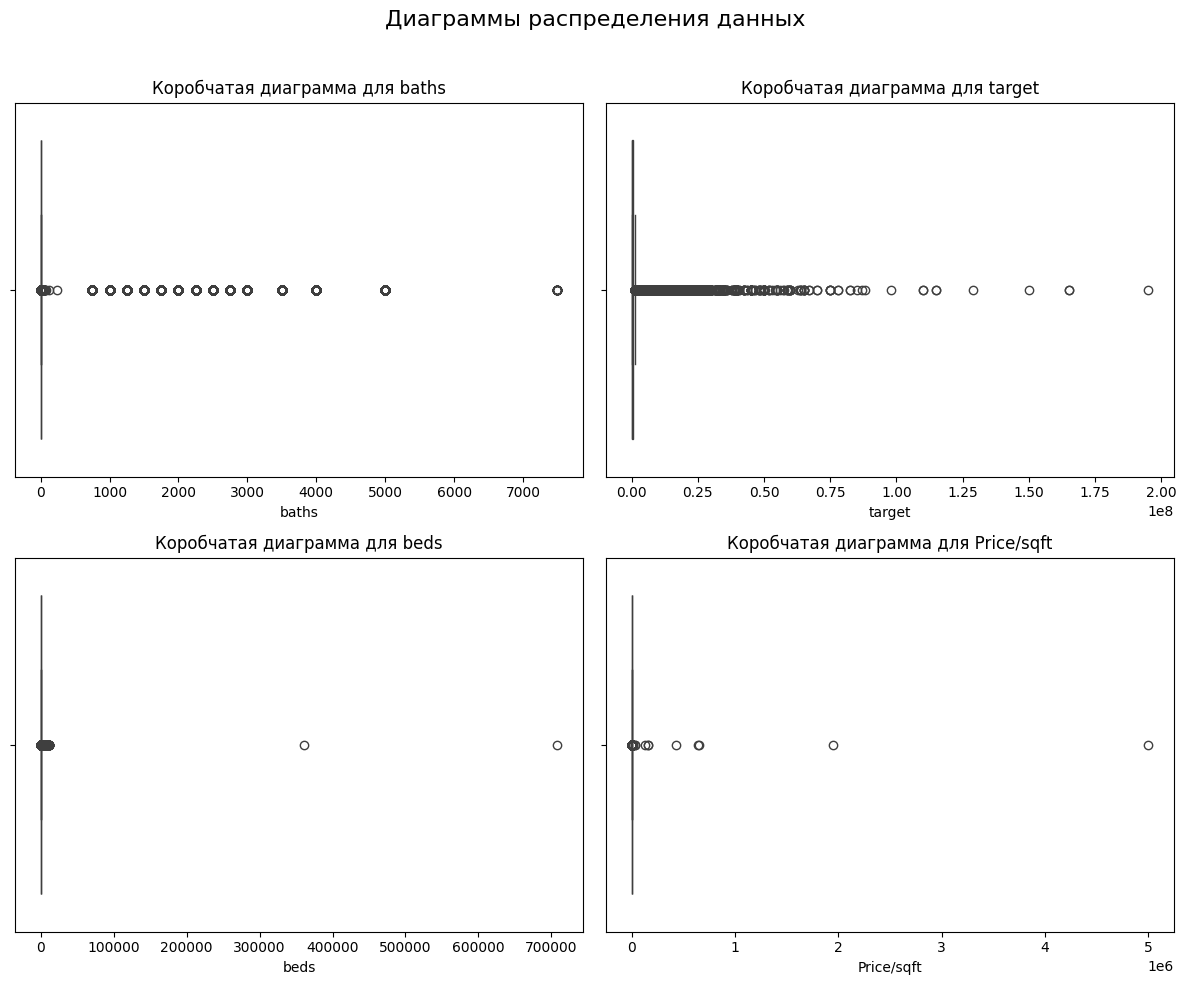

In [222]:
# Убедимся, что у нас есть необходимые данные
data.reset_index(drop=True, inplace=True)
columns = ['baths', 'target', 'beds', 'Price/sqft']

# Создаем подграфики с двумя рядами и двумя колонками (всего 4 графика)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Устанавливаем заголовок для всего графика
fig.suptitle('Диаграммы распределения данных', fontsize=16)

# Коробчатая диаграмма для первого столбца
sns.boxplot(x=data[columns[0]], ax=axes[0, 0])
axes[0, 0].set_title(f"Коробчатая диаграмма для {columns[0]}")

# Коробчатая диаграмма для второго столбца
sns.boxplot(x=data[columns[1]], ax=axes[0, 1])
axes[0, 1].set_title(f"Коробчатая диаграмма для {columns[1]}")

# Коробчатая диаграмма для третьего столбца
sns.boxplot(x=data[columns[2]], ax=axes[1, 0])
axes[1, 0].set_title(f"Коробчатая диаграмма для {columns[2]}")

# Коробчатая диаграмма для четвертого столбца
sns.boxplot(x=data[columns[3]], ax=axes[1, 1])
axes[1, 1].set_title(f"Коробчатая диаграмма для {columns[3]}")

# Корректируем расположение графиков
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Показываем графики
plt.show()


In [223]:
#В данном случае я буду удалять "строгим способом" основываясь на том, какие значения явно выходят на рамки нормальных данных и веду к аномалиям
data = data[(data['baths'] < 10) | (data['baths'].isnull())]
data = data[(data['target'] <= 40e6) & (data['target']>1e3)]
data = data[(data['beds'] < 20) | (data['beds'].isnull())]
data = data[(data['Price/sqft'] < 4e3) | (data['Price/sqft'].isnull())]

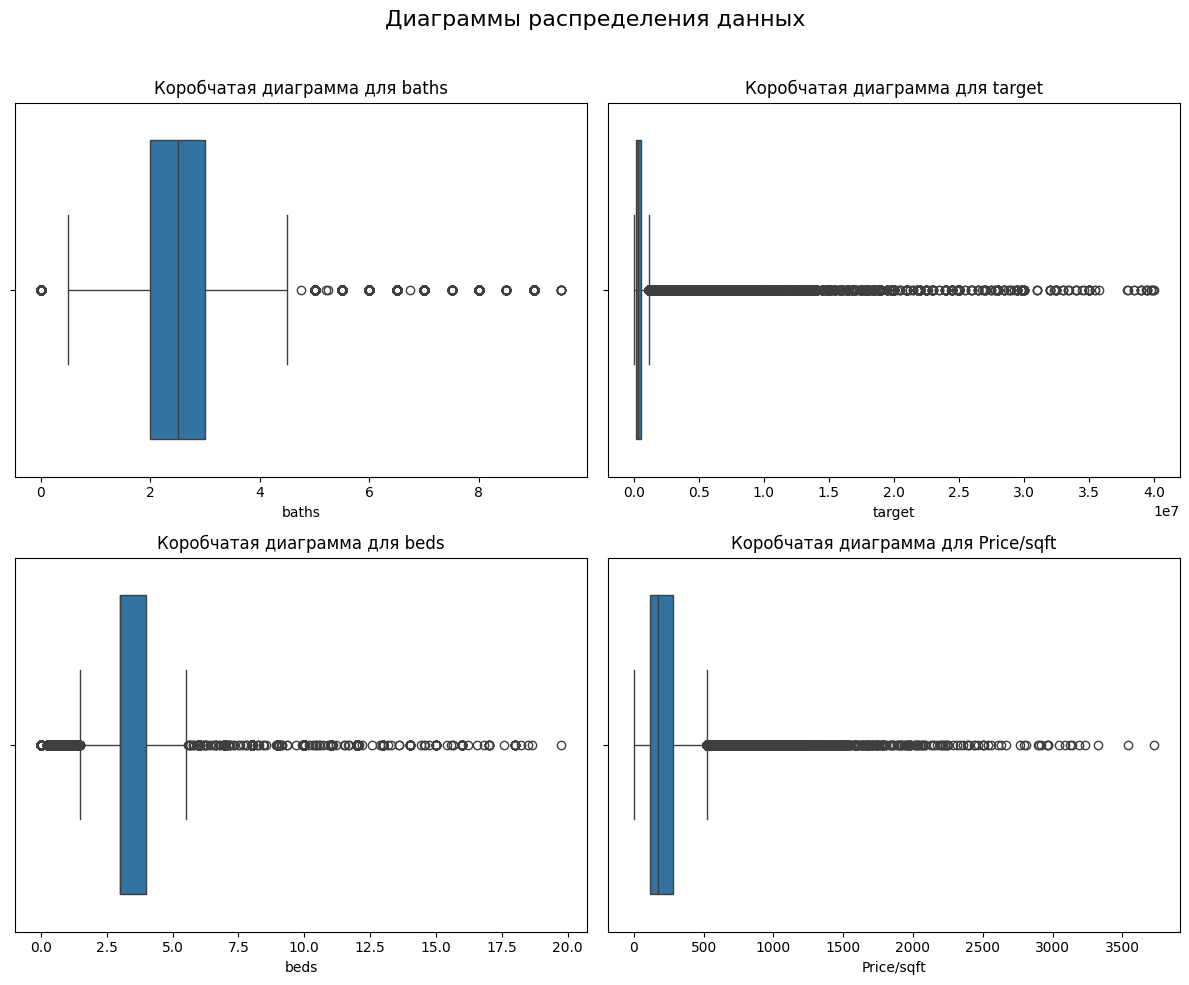

In [224]:
# Убедимся, что у нас есть необходимые данные
data.reset_index(drop=True, inplace=True)
columns = ['baths', 'target', 'beds', 'Price/sqft']

# Создаем подграфики с двумя рядами и двумя колонками (всего 4 графика)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Устанавливаем заголовок для всего графика
fig.suptitle('Диаграммы распределения данных', fontsize=16)

# Коробчатая диаграмма для первого столбца
sns.boxplot(x=data[columns[0]], ax=axes[0, 0])
axes[0, 0].set_title(f"Коробчатая диаграмма для {columns[0]}")

# Коробчатая диаграмма для второго столбца
sns.boxplot(x=data[columns[1]], ax=axes[0, 1])
axes[0, 1].set_title(f"Коробчатая диаграмма для {columns[1]}")

# Коробчатая диаграмма для третьего столбца
sns.boxplot(x=data[columns[2]], ax=axes[1, 0])
axes[1, 0].set_title(f"Коробчатая диаграмма для {columns[2]}")

# Коробчатая диаграмма для четвертого столбца
sns.boxplot(x=data[columns[3]], ax=axes[1, 1])
axes[1, 1].set_title(f"Коробчатая диаграмма для {columns[3]}")

# Корректируем расположение графиков
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Показываем графики
plt.show()


В целом диаграммы улучшиличь и теперь действительно похожи на правдивые данные   
Так же заметим огромный разброс в целевой переменной, и из неё истекает и **Price\sqft**, это надо будет учесть при обучении модели

### Отдельно поработаем с столбцом sqft

In [225]:
data['sqft'].describe()

count    3.184090e+05
mean     6.803042e+03
std      1.626435e+06
min      0.000000e+00
25%      1.239000e+03
50%      1.795000e+03
75%      2.575000e+03
max      7.959794e+08
Name: sqft, dtype: float64

In [226]:
Q1 = data['sqft'].quantile(0.25)
Q3 = data['sqft'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = 300
upper_bound = Q3 + 1.5 * IQR

data = data[(data['sqft'].isna()) |(data['sqft'] >= lower_bound) & (data['sqft'] <= upper_bound)]
data.reset_index(drop=True, inplace=True)

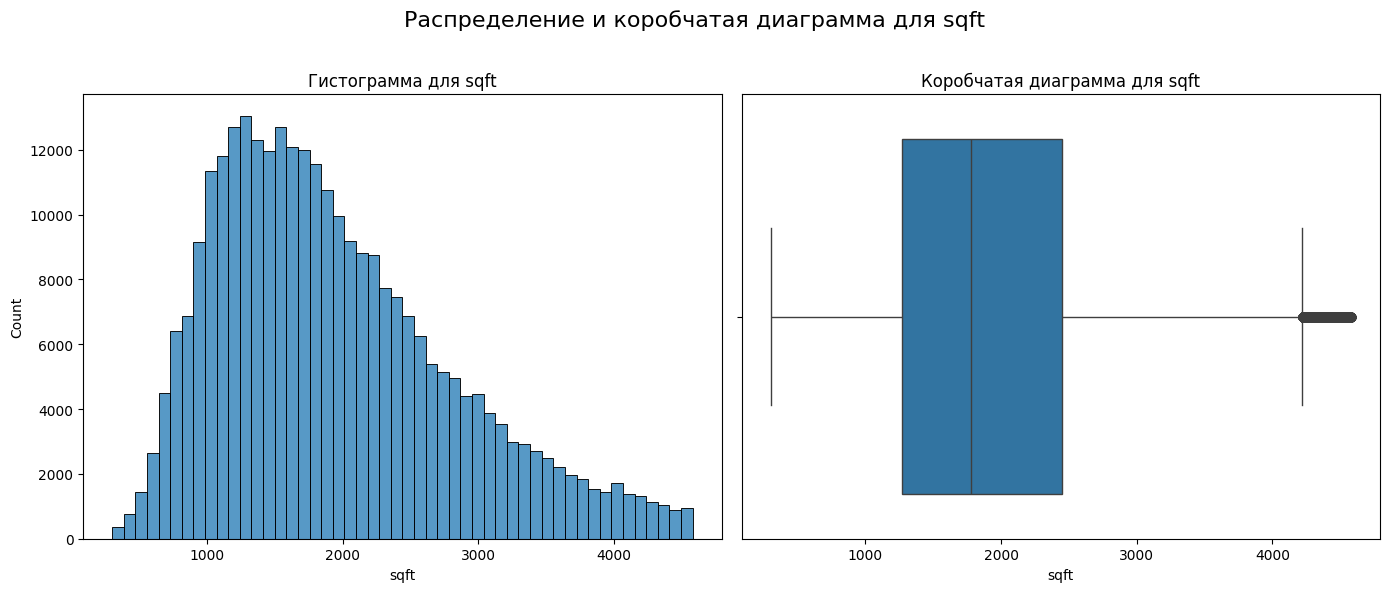

In [227]:
# Создание фигуры с двумя графиками (гистограмма и коробчатая диаграмма)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Гистограмма для 'sqft'
sns.histplot(data['sqft'], bins=50, kde=False, ax=axes[0])
axes[0].set_title("Гистограмма для sqft")

# Коробчатая диаграмма для 'sqft'
sns.boxplot(x=data['sqft'], ax=axes[1])
axes[1].set_title("Коробчатая диаграмма для sqft")

# Общий заголовок
fig.suptitle('Распределение и коробчатая диаграмма для sqft', fontsize=16)

# Центрирование заголовков и отступов
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Отображение графиков
plt.show()

#### 1. В данном столбце больше не обнаружено аномалий.
#### 2. Распределение в этом столбце имеет логнормальный характер, что может быть полезным в будущем.


## Замещение пропущенных значений

In [228]:
def corr_row(data: pd.DataFrame, col: str) -> px.imshow:
    """Вычисляет корреляцию заданного столбца с другими и возвращает визуализацию."""
    
    correlation_col = data.corr()[col]

    correlation_df = correlation_col.reset_index()
    correlation_df.columns = ['Feature', 'Correlation']

    fig = px.imshow(
        correlation_df.set_index('Feature').T, 
        labels=dict(x='Feature', y='Correlation'),
        title=f'Correlation with {col}',
        color_continuous_scale='Viridis'
    )

    return fig


data.reset_index(drop=True, inplace=True)
chart_data = data.select_dtypes(include=['number', 'bool'])
chart_data = chart_data.dropna()


columns = ['sqft', 'baths', 'beds','Price/sqft']
fig = make_subplots(
        rows=2, cols=2, 
        subplot_titles=[f"Гистограмма для {columns[0]}", 
                        f"Гистограмма  для {columns[1]}",
                        f"Гистограмма для {columns[2]}", 
                        f"Гистограмма  для {columns[3]}"]
    )


for index, col in enumerate(columns, start=1):
    new_fig = corr_row(chart_data, col)
    for trace in new_fig.data:  
        fig.add_trace(trace, row=(index-1)//2+1, col=(index-1)%2+1)


fig.update_layout(height=1000, 
                  width=1600, 
                  title_text="Корреляции по столбцам",
                  title_x=0.5)
fig.show()


In [229]:
def round_to_nearest_half(value):
    return round(value * 2)/2

data = inplace_col(data, ['baths', 'beds', 'PrivatePool', 'Average Rating'], 'sqft')


Fitting 5 folds for each of 72 candidates, totalling 360 fits
данные для sqft
{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}
Параметры модели: None
MAE (Mean Absolute Error): 410.24
R² Score: 0.58
Standard deviation of sqft: 870.19

Baseline MAE (Mean Absolute Error): 700.08



In [230]:
data = inplace_col(data, ['sqft', 'beds', 'PrivatePool', 'Average Rating', 'property_age'], 'baths')
data['baths'] = data['baths'].apply(round_to_nearest_half)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
данные для baths
{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}
Параметры модели: None
MAE (Mean Absolute Error): 0.44
R² Score: 0.62
Standard deviation of baths: 0.96

Baseline MAE (Mean Absolute Error): 0.77



In [231]:
data  = inplace_col(data, ['sqft', 'baths', 'PrivatePool', 'Average Rating'], 'beds')
data['beds'] = data['beds'].apply(round_to_nearest_half)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
данные для beds
{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}
Параметры модели: None
MAE (Mean Absolute Error): 0.56
R² Score: 0.51
Standard deviation of beds: 1.13

Baseline MAE (Mean Absolute Error): 0.83



In [232]:
data = inplace_col(data, ['propertyType', 'baths', 'state_0', 'state_1', 'city_0', 'city_1', 'Average Rating','property_age'], 'Price/sqft')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
данные для Price/sqft
{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}
Параметры модели: None
MAE (Mean Absolute Error): 66.26
R² Score: 0.58
Standard deviation of Price/sqft: 178.66

Baseline MAE (Mean Absolute Error): 126.96



### Заполнение данных прошло успешно, и каждая модель ошибалась почти в 2 раза меньше чем замена на среднее, так же проверим как это повлияло на корреляцию с ключевой переменной

In [233]:
find_missing_and_object_columns(data)

                Missing Values data Type
stories                 132854   float64
lotsize                  86653   float64
Average Rating            3587   float64
street                       0    object
city                         0    object
zipcode                      0    object
state                        0    object


In [234]:
Heat(data, 'lotsize')

#### Из оставшихся необработанных столбцов у нас остались только stories и lotsize. Первый имеет пропуски почти в 50% строк, а второй не имеет корреляции с другими данными, ввиду чего удалим данные признаки

In [235]:
data.dropna(subset = ['Average Rating'], inplace=True)
data.drop(['lotsize', 'stories'], axis=1, inplace=True)

print('Значения с типами object и пропущенными значениями: ')
print(find_missing_and_object_columns(data))
print(f'Размерность данных: {data.shape}')


Значения с типами object и пропущенными значениями: 
         Missing Values data Type
street                0    object
city                  0    object
zipcode               0    object
state                 0    object
None
Размерность данных: (323928, 30)


In [236]:
data['has_fireplace'] = data['count_fireplace'].apply(lambda x: 1 if x > 0 else 0)
data.drop(['count_fireplace'], axis=1, inplace=True)

data['has_parking'] = data['Parking'].apply(lambda x: 1 if x > 0 else 0)
data.drop('Parking', axis=1, inplace=True)

data['lowest_price'] = data['sqft'] * data['Price/sqft']
data = data[(data['lowest_price'] > 5)]
data.loc[data['lowest_price'] > 5e5, 'lowest_price'] = None

data['sum_baths_beds'] = data['beds'] + data['baths']

data.loc[data['baths'] == 0, 'baths'] = None
data['sqft/baths'] = data['sqft'] / data['baths']

data.drop(['beds', 'baths'], axis=1, inplace = True)

In [237]:
Heat(data, 'target')

### Наблюдения о корреляции признаков

Можно заметить, что многие признаки стали слабокоррелирующими с целевой переменной. Загвоздка заключается в том, что цены на квартиры в данных значительно разнятся. Основная масса находится в диапазоне до 1_000_000, в то время как более высокие цены добавляют много шума в данные, что может негативно сказаться на метриках в будущем.

Однако удалять такие данные нельзя, поскольку квартиры с высокой ценой можно отнести к VIP-категории. Отказ от их предсказания будет нецелесообразен.

К данному вопросу мы вернёмся позже. А сейчас снова взглянем на распределение целевой переменной, чтобы увидеть это наглядно, а также на две матрицы корреляции.


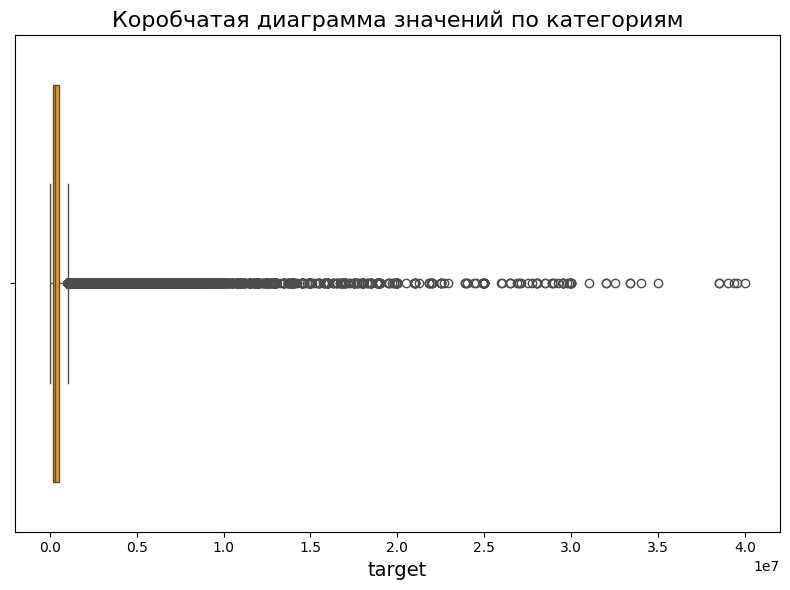

In [238]:
Box(data, 'target')

In [239]:

data.reset_index(drop=True, inplace=True)
# Создаем подграфики с двумя колонками
fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=[f'Корреляция с target до 1e6', f'Корреляция с target после 1e6']
)


df = data[data['target'] <= 1e6].select_dtypes(include=['number', 'bool'])
correlation_baths = df.corr()['target']
correlation_df = pd.DataFrame(correlation_baths).reset_index()
correlation_df.columns = ['Feature', 'Correlation']


heatmap_fig = px.imshow(
    correlation_df.set_index('Feature').T,  # Транспонируем для корректного отображения
    labels=dict(x='Feature', y='Correlation'),
    color_continuous_scale='Viridis'
)
fig.add_traces(heatmap_fig.data, rows=1, cols=1)



df = data[data['target'] > 1e6].select_dtypes(include=['number', 'bool'])
correlation_baths = df.corr()['target']
correlation_df = pd.DataFrame(correlation_baths).reset_index()
correlation_df.columns = ['Feature', 'Correlation']


heatmap_fig = px.imshow(
    correlation_df.set_index('Feature').T,  # Транспонируем для корректного отображения
    labels=dict(x='Feature', y='Correlation'),
    color_continuous_scale='Viridis'
)
fig.add_traces(heatmap_fig.data, rows=1, cols=2)

fig.update_layout(
        title_text=f'Матрицы корреляции для target', 
        title_x=0.5,  
        showlegend=False 
    )

fig.show()


## Что и требовалось доказать

Можно невооруженным глазом заметить разницу в матрицах корреляции в зависимости от диапазона переменной.


In [240]:
data.reset_index(drop=True, inplace=True)
chart_data = data.select_dtypes(include=['number', 'bool']).dropna()

corr_matrix = chart_data.corr()

print(f'размерность: {data.shape}')

rank = np.linalg.matrix_rank(corr_matrix)
print(f"Ранг матрицы корреляции: {rank}")

determinant = np.linalg.det(corr_matrix)
print(f"Определитель матрицы корреляции: {determinant:.7f}")

размерность: (322865, 31)
Ранг матрицы корреляции: 27
Определитель матрицы корреляции: 0.0001489


#### Ранг матрицы корреляции максимален, однако определитель очень мал, что указывает на то, что матрица корреляции близка к вырожденной или имеет почти линейно зависимые строки и столбцы. Это может свидетельствовать о наличии мультиколлинеарности среди признаков, что затрудняет интерпретацию данных и может негативно сказываться на производительности моделей машинного обучения, таких как регрессия.



#### Давайте снова разделим наш датасет на два диапазона и проверим модели с использованием `xgb.XGBRegressor`.


In [241]:
data = data.select_dtypes(['number', 'bool'])
params = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}

xgb_model = xgb.XGBRegressor(**params, random_state=42)

#Датасет для квартир в ценовом диапозоне до 1_000_000
graph_df = data[data['target'] <= 1e6]
X = graph_df.drop('target', axis=1)
y = graph_df['target']


xgb_model.fit(X, y)


importances = xgb_model.feature_importances_


importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


#Датасет для квартир в ценовом диапозоне после 1_000_000
graph_df_vip = data[data['target'] > 1e6]
X = graph_df_vip.drop('target', axis=1)
y = graph_df_vip['target']

# Обучение модели
xgb_model.fit(X, y)


importances = xgb_model.feature_importances_


importance_df_vip = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})
importance_df_vip = importance_df_vip.sort_values(by='Importance', ascending=False)


In [242]:

# fig = make_subplots(
#         rows=2, cols=1, 
#         subplot_titles=[f"Гистограмма для importance_df_vip", f"Коробчатая диаграмма для importance_df"],
#     )


# bar_fig_1 = px.bar(
#     importance_df,
#     x='Importance',
#     y='Feature',
#     orientation='h',
#     title='Важность признаков модели XGBRegressor',
#     labels={'Importance': 'Важность признаков', 'Feature': 'Признак'}
# )
# fig.add_traces(bar_fig_1.data, rows=1, cols=1)


# bar_fig_2 = px.bar(
#     importance_df_vip,
#     x='Importance',
#     y='Feature',
#     orientation='h',
#     title='Важность признаков модели XGBRegressor',
#     labels={'Importance': 'Важность признаков', 'Feature': 'Признак'}
# )
# fig.add_traces(bar_fig_2.data, rows=2, cols=1)


# fig.update_layout(
#     yaxis_title='Признак',
#     xaxis_title='Важность признаков',
#     height=1600,
# )

# fig.show()

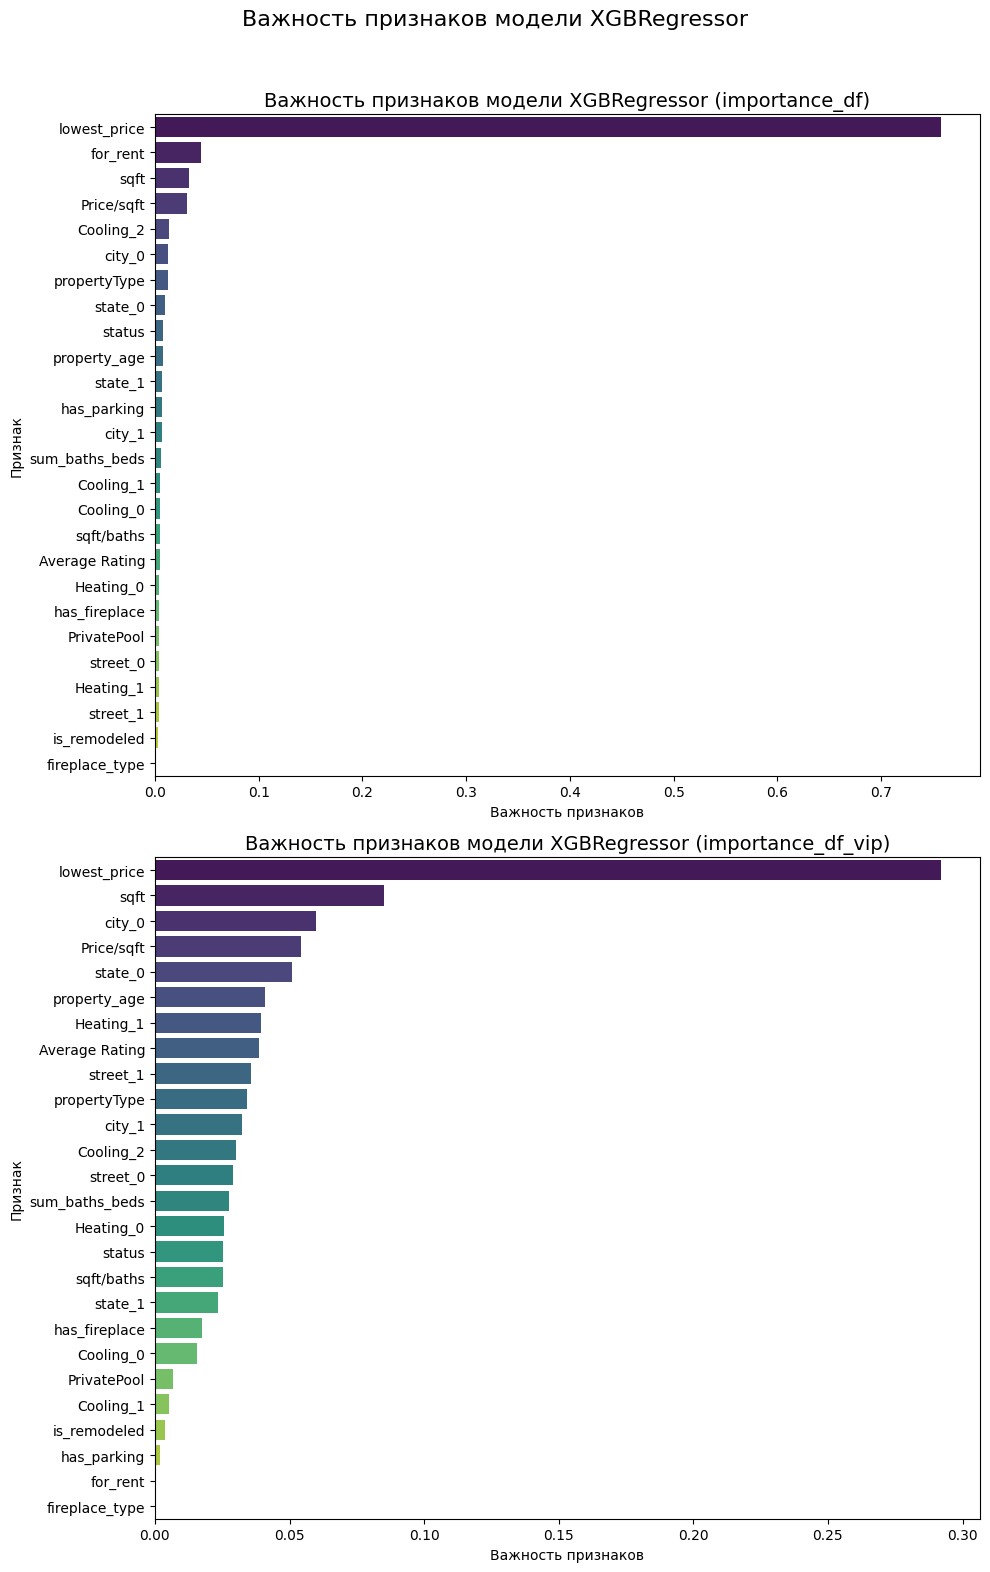

In [243]:
# Создаем подграфики с двумя рядами
fig, axes = plt.subplots(2, 1, figsize=(10, 16))

# Устанавливаем общий заголовок для всей фигуры
fig.suptitle('Важность признаков модели XGBRegressor', fontsize=16)

# Горизонтальная гистограмма для первого DataFrame (importance_df)
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df, 
    ax=axes[0], 
    orient='h', 
    palette='viridis'
)
axes[0].set_title('Важность признаков модели XGBRegressor (importance_df)', fontsize=14)
axes[0].set_xlabel('Важность признаков')
axes[0].set_ylabel('Признак')

# Горизонтальная гистограмма для второго DataFrame (importance_df_vip)
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df_vip, 
    ax=axes[1], 
    orient='h', 
    palette='viridis'
)
axes[1].set_title('Важность признаков модели XGBRegressor (importance_df_vip)', fontsize=14)
axes[1].set_xlabel('Важность признаков')
axes[1].set_ylabel('Признак')

# Корректируем компоновку
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Показываем графики
plt.show()

### На основе этих данных создаим функцию, которые будут удалять признаки в зависимости от того, какой именно диапазон нам нужен

In [244]:
def get_hight_data(data: pd.DataFrame) -> pd.DataFrame:
    """Извлекает числовые и булевы столбцы из датафрейма для обучения модели на квартирах стоимостью выше 1 миллиона."""

    hight_data = data.select_dtypes(['number', 'bool'])
    cols_to_drop = ['Heating_0', 'state_1', 'sqft/baths', 'Cooling_0', 'Cooling_1', 'Cooling_2', 'PrivatePool', 'is_remodeled', 'has_parking', 'for_rent', 'fireplace_type']
    
    for col in cols_to_drop:
        if col in hight_data.columns:
            hight_data = hight_data.drop(col, axis=1)

    hight_data.reset_index(drop=True, inplace=True)
    return hight_data

def get_low_data(data: pd.DataFrame) -> pd.DataFrame:
    """Извлекает числовые и булевы столбцы из датафрейма для обучения модели на квартирах стоимостью до 1 миллиона"""

    lower_drop_col = ['fireplace_type', 'for_rent', 'is_remodeled', 'Heating_0', 'Heating_1', 'PrivatePool', 'street_0', 'street_1', 'has_fireplace', 'Cooling_0', 'Cooling_1']
    low_data = data.select_dtypes(include=['number', 'bool'])

    for col in lower_drop_col:
        if col in low_data.columns:
            low_data = low_data.drop(col, axis=1)

    low_data.reset_index(drop=True, inplace=True)
    return low_data

In [245]:
def check_data(data: pd.DataFrame, model: Any, dropna = False) -> None:
    """
    Оценивает производительность модели на данных, используя кросс-валидацию.
    
    Параметры:
    - data (DataFrame): Входной набор данных, должен содержать столбец 'target'.
    - model: Модель для оценки (например, XGBRegressor).
    - dr (bool): Если True, удаляет строки с пропущенными значениями.
    
    Вывод:
    - MAE (Mean Absolute Error): Средняя абсолютная ошибка.
    - R² Score: Коэффициент детерминации.
    """

    if dropna:
        data = data.dropna()
        
    
    data = data.select_dtypes(include=['number', 'bool'])
    X = data.drop('target', axis=1)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = data['target']
   
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

    mae_mean = -np.mean(mae_scores)
    r2_mean = np.mean(r2_scores)
 
    

    print(f"MAE (Mean Absolute Error): {mae_mean:.2f}")
    print(f"R² Score: {r2_mean:.2f}")


def check_data_log(data: pd.DataFrame, model: Any, dr: bool = False) -> None:
    """
    Оценивает производительность модели на логарифмированных данных.
    
    Параметры:
    - data (DataFrame): Входной набор данных, должен содержать столбец 'target'.
    - model: Модель для обучения и оценки (например, XGBRegressor).
    - dr (bool): Если True, удаляет строки с пропущенными значениями.
    
    Вывод:
    - MAE (Mean Absolute Error): Средняя абсолютная ошибка.
    - R² Score: Коэффициент детерминации.
    """
    if dr:
        data = data.dropna()
        
    
    data = data.select_dtypes(include=['number', 'bool'])
    X = data.drop('target', axis=1)
    scaler = StandardScaler()

    y = data['target']
    y = np.log1p(y)

   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

 
    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_test)
    
    y_pred = np.expm1(y_pred_log)
    y_test_true = np.expm1(y_test)
    
    mae = mean_absolute_error(y_test_true, y_pred)
    r2 = r2_score(y_test_true, y_pred)
    
    
    print(f"MAE (Mean Absolute Error): {mae:.0f}")
    print(f"R² Score: {r2:.2f}")

#### Теперь проверим как ведёт себя модель с одними и теже параметрами на данных без удаления призаков, и с удалением

In [246]:
params = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}
model = xgb.XGBRegressor(**params, random_state = 42)


check_df = data[data['target'] <= 1e6]
check_df_vip = data[data['target'] > 1e6]

check_data(check_df, model)
check_data(check_df_vip, model)

MAE (Mean Absolute Error): 21004.19
R² Score: 0.92
MAE (Mean Absolute Error): 592078.31
R² Score: 0.49


In [247]:
check_df = get_low_data(check_df)
check_df_vip = get_hight_data(check_df_vip)

check_data(check_df, model)
check_data(check_df_vip, model)

MAE (Mean Absolute Error): 20669.46
R² Score: 0.92
MAE (Mean Absolute Error): 588889.11
R² Score: 0.49


In [248]:
check_df_vip.reset_index(drop=True, inplace=True)
chart_data = check_df_vip.select_dtypes(include=['number', 'bool']).dropna()

corr_matrix = chart_data.corr()

print(f'размерность: {data.shape}')

rank = np.linalg.matrix_rank(corr_matrix)
print(f"Ранг матрицы корреляции: {rank}")

determinant = np.linalg.det(corr_matrix)
print(f"Определитель матрицы корреляции: {determinant:.7f}")

размерность: (322865, 27)
Ранг матрицы корреляции: 16
Определитель матрицы корреляции: 0.0052006


In [249]:
check_df.reset_index(drop=True, inplace=True)
chart_data = check_df.select_dtypes(include=['number', 'bool']).dropna()

corr_matrix = chart_data.corr()

print(f'размерность: {data.shape}')

rank = np.linalg.matrix_rank(corr_matrix)
print(f"Ранг матрицы корреляции: {rank}")

determinant = np.linalg.det(corr_matrix)
print(f"Определитель матрицы корреляции: {determinant}")

размерность: (322865, 27)
Ранг матрицы корреляции: 16
Определитель матрицы корреляции: 0.0038974165949666644


Виднеются совсем небольшие, но улучшения в значениях метрик   
Но что более важно, проверим определитель матрицы

# Обучение модели

## Решение проблемы предсказания цен в диапазоне до и свыше 1 миллиона долларов

### 1. Использование стекинга
В данном подходе мы применяем стекинг, используя две модели для предсказания цен в двух разных диапазонах: до 1 миллиона долларов и свыше. Для определения, в какой диапазон попадает объект, мы также обучаем модель, которая предсказывает кластер, соответствующий диапазону. Таким образом, мы создаем сложную модель, которая объединяет прогнозы двух отдельных моделей и модель-кластеризатор.

### 2. Моделирование на основе кластеризации
В этом подходе мы аналогичным образом используем две модели для предсказания цен в разных диапазонах. Однако, вместо использования стекинга, мы сначала предсказываем кластер, в который попадает объект, а затем на основе этого предсказания выбираем модель для предсказания конкретной цены. Это позволяет гибко переключаться между моделями в зависимости от кластеризации объекта.

### 3. Наивное обучение одной модели
Наиболее простой подход — обучить одну модель/ансамбль на всем датасете, независимо от диапазона цен. Этот метод предполагает, что одна модель будет справляться с прогнозированием цен по всему диапазону, что может быть менее эффективно в условиях значительного разброса данных.

## Определение наилучшей модели для решения задачи регрессии

В качестве базовой модели мы используем `Ridge`. Если предсказательная способность других моделей окажется ниже, чем у `Ridge`, будем считать, что эти модели не справляются с задачей.

Мы будем рассматривать следующие модели для регрессии:
- **`LGBMRegressor`**
- **`XGBRegressor`**
- **`DecisionTreeRegressor`**

Почему именно эти модели? Дело в том, что в данных содержится большое количество пропусков и опечаток, что может быть связано с человеческим фактором. Хотя мы предприняли меры по обработке пропусков, невозможно гарантировать, что все пропуски будут заполнены полностью. Поэтому важно использовать модели, которые могут эффективно справляться с отсутствием данных, чтобы избежать потенциальных убытков для компании.


In [250]:
def train_and_evaluate_model(
    data: pd.DataFrame, 
    model: Any, 
    param_grid: dict, 
    dr: bool = False, 
    name: str = None, 
    target_col: str = 'target', 
    test_size: float = 0.2, 
    random_state: int = 42
) -> Any:
    """
    Обучение модели с помощью GridSearchCV и оценка её качества.

    Parameters:
    - data: pandas DataFrame, содержащий данные для обучения
    - model: Any, модель для обучения (например, Ridge(), XGBRegressor(), LGBMRegressor(), DecisionTreeRegressor())
    - param_grid: словарь с гиперпараметрами для подбора
    - dr: булевый флаг, указывающий, следует ли удалять пропуски (по умолчанию False)
    - name: название модели для вывода результатов
    - target_col: название целевой переменной (по умолчанию 'target')
    - test_size: доля тестовой выборки (по умолчанию 0.2)
    - random_state: seed для генератора случайных чисел (по умолчанию 42)

    Returns:
    - best_model: лучшая модель после подбора гиперпараметров
    """
    if dr:
        data.dropna(inplace=True)
    
    # Разделение данных на признаки и целевую переменную
    X = data.drop(target_col, axis=1)
    y = data[target_col]

    # Разделение на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Создание объекта GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=5,
        verbose=1,
        n_jobs=-1
    )

    # Подбор гиперпараметров
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Оценка модели
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Информация по {name}:')
    print(f"Лучшие параметры: {grid_search.best_params_}")
    print(f"Средний MAE: {round(mae,0):.2f}")
    print(f"R² Score: {round(r2,2):.2f}")
    print()

    return best_model

In [251]:
# Определение параметров для Ridge
first_data = data[data['target'] <= 1e6]
first_data = get_low_data(first_data)

ridge_param_grid = {
    'alpha': [0.1, 1, 10, 100]
}
best_ridge_model = train_and_evaluate_model(
    data=first_data,
    model=Ridge(),
    param_grid=ridge_param_grid,
    dr=True,
    name='Ridge'
)
#params = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}
# Определение параметров для XGBRegressor
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [6, 9],
    'min_child_weight': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [1]
}
best_xgb_model = train_and_evaluate_model(
    data=first_data,
    model=xgb.XGBRegressor(random_state=42),
    param_grid=xgb_param_grid,
    dr=True,
    name='XGBRegressor'
)



# Определение параметров для LGBMRegressor
lgbm_param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.1],  
    'num_leaves': [31, 40], 
    'max_depth': [10, 15], 
    'min_child_samples': [20, 30],
    'subsample': [0.9],  
    'colsample_bytree': [0.9]  
}
best_lgbm_model = train_and_evaluate_model(
    data=first_data,
    model=lgb.LGBMRegressor(random_state=42),
    param_grid=lgbm_param_grid,
    dr=True,
    name='LGBMRegressor'
)


# Определение параметров для DecisionTreeRegressor
dt_param_grid = {
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}
best_dt_model = train_and_evaluate_model(
    data=first_data,
    model=DecisionTreeRegressor(random_state=42),
    param_grid=dt_param_grid,
    dr=True,
    name='DecisionTreeRegressor'
)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Информация по Ridge:
Лучшие параметры: {'alpha': 100}
Средний MAE: 34471.00
R² Score: 0.64

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Информация по XGBRegressor:
Лучшие параметры: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}
Средний MAE: 19032.00
R² Score: 0.82

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1981
[LightGBM] [Info] Number of data points in the train set: 188409, number of used features: 15
[LightGBM] [Info] Start training from score 253854.920837
Информация по LGBMRegressor:
Лучшие параметры: {'colsample_bytree': 0.9, 'learning_rate':

In [252]:
# Определение параметров для Ridge
second_data = data[data['target'] > 1e6]
second_data = get_hight_data(second_data)

ridge_param_grid = {
    'alpha': [0.1, 1, 10, 100]
}
best_ridge_model_vip = train_and_evaluate_model(
    data=second_data,
    model=Ridge(),
    param_grid=ridge_param_grid,
    dr=True,
    name='Ridge'
)

xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [6, 9],
    'min_child_weight': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [1]
}
best_xgb_model_vip = train_and_evaluate_model(
    data=second_data,
    model=xgb.XGBRegressor(random_state=42),
    param_grid=xgb_param_grid,
    dr=True,
    name='XGBRegressor'
)



# Определение параметров для LGBMRegressor
lgbm_param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.1],  
    'num_leaves': [31, 40], 
    'max_depth': [10, 15], 
    'min_child_samples': [20, 30],
    'subsample': [0.9],  
    'colsample_bytree': [0.9]  
}
best_lgbm_model_vip = train_and_evaluate_model(
    data=second_data,
    model=lgb.LGBMRegressor(random_state=42),
    param_grid=lgbm_param_grid,
    dr=True,
    name='LGBMRegressor'
)


# Определение параметров для DecisionTreeRegressor
dt_param_grid = {
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}
best_dt_model_vip = train_and_evaluate_model(
    data=second_data,
    model=DecisionTreeRegressor(random_state=42),
    param_grid=dt_param_grid,
    dr=True,
    name='DecisionTreeRegressor'
)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Информация по Ridge:
Лучшие параметры: {'alpha': 100}
Средний MAE: 1781705.00
R² Score: 0.27

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Информация по XGBRegressor:
Лучшие параметры: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Средний MAE: 1227658.00
R² Score: 0.55

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 6206, number of used features: 15
[LightGBM] [Info] Start training from score 3766179.227683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}

### Как можно заметить во всех случая выйграла модель XGBReg, в таком случае именно её и будеи использовать для предсказания значений

Для задачи я буду использовать RandomForestClassifier, вот главные причины:
1. Обработка пропущенных данных
2. Устойчивость к переобучению 
3. Хорошая масштабируемость

In [253]:
data['cluster'] = data['target'].apply(lambda x: 1 if x <= 1e6 else 0)
# Выбираем числовые и булевы признаки для модели
X = data.select_dtypes(include=['number', 'bool']).drop(['target', 'cluster'], axis=1)
y = data['cluster']


scaler_cluster = StandardScaler()
X_scaled = scaler_cluster.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)

# Определяем сетку гиперпараметров для подбора
#тут выбраны по 1 варианту ввиду долго обучения, на данный момент тут находятся лучшие параметры, но можно добавить и другие
param_grid = {
    'n_estimators': [200],  
    'max_depth': [15],   
    'min_samples_split': [5], 
    'min_samples_leaf': [ 4]     
}


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

cluster_model = grid_search.best_estimator_

y_pred = cluster_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Лучшие гиперпараметры: {grid_search.best_params_}")
print(f"Точность (Accuracy): {accuracy:.2f}")
print(f"Точность по классу (Precision): {precision:.2f}")
print(f"Полнота (Recall): {recall:.2f}")
print(f"F1-score: {f1:.2f}")


#Лучшие гиперпараметры: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Лучшие гиперпараметры: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Точность (Accuracy): 0.94
Точность по классу (Precision): 0.94
Полнота (Recall): 1.00
F1-score: 0.97


# A\B тестирование

## Обучение при помощи тактики Стекинга

In [254]:

data.reset_index(drop=True, inplace=True)

X = data.drop(['target','cluster'], axis=1)
y = data['target']

# Получаем подмножества данных
X_low = get_low_data(X)
X_hight = get_hight_data(X)

X_cluster  = data.drop(['target', 'cluster'], axis=1)
y_cluster = data['cluster']

X_cluster = scaler_cluster.fit_transform(X_cluster)


# Разбиение данных на обучающую и тестовую выборки
X_train_high, X_test_high, y_train, y_test = train_test_split(X_hight, y, test_size=0.2, random_state=42)
X_train_low, X_test_low, y_train, y_test = train_test_split(X_low, y, test_size=0.2, random_state=42)
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)


X_train_high_pred = best_xgb_model_vip.predict(X_train_high)
X_train_low_pred = best_xgb_model.predict(X_train_low)
X_train_cluster_pred = cluster_model.predict(X_train_cluster) 

# Предсказания на тестовом наборе данных
X_test_high_pred = best_xgb_model_vip.predict(X_test_high)
X_test_low_pred = best_xgb_model.predict(X_test_low)
X_test_cluster_pred = cluster_model.predict(X_test_cluster)

X_train_meta = np.column_stack((X_train_high_pred, X_train_low_pred, X_train_cluster_pred))
X_test_meta = np.column_stack((X_test_high_pred, X_test_low_pred, X_test_cluster_pred))



param_grid = {
    'n_estimators': [150],
    'max_depth': [10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'bootstrap': [True, False]
}



meta_model = RandomForestRegressor(random_state=42)


grid_search = GridSearchCV(meta_model, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train_meta, y_train)
best_meta_model = grid_search.best_estimator_

y_pred_meta = best_meta_model.predict(X_test_meta)

mae = mean_absolute_error(y_test, y_pred_meta)
r2 = r2_score(y_test, y_pred_meta)

print(f"MAE метамодели: {mae:.2f}")
print(f"R2 метамодели: {r2:.2f}")
print(f"Лучшие гиперпараметры: {grid_search.best_params_}", end='\n\n')


#{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}

Fitting 5 folds for each of 8 candidates, totalling 40 fits
MAE метамодели: 159631.86
R2 метамодели: 0.54
Лучшие гиперпараметры: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}



In [260]:
class ModelSelector(BaseEstimator, RegressorMixin):
    def __init__(self, classifier, model_low, model_high):
        """
        classifier: модель для выбора между low и high моделями
        model_low: модель для предсказания значений ниже 1 миллиона
        model_high: модель для предсказания значений выше 1 миллиона
        """
        self.classifier = classifier
        self.model_low = model_low
        self.model_high = model_high

        self.high_name = None
        self.low_name = None


    def fit(self, X: pd.DataFrame, y: pd.Series) -> 'ModelSelector':
       # Разделяем данные по целевому значению

        X_cluster = X.select_dtypes(include=['number', 'bool'])
        y_cluster = (y > 1e6).astype(int)  # Создаём метки для клaсификации
        self.classifier.fit(X_cluster, y_cluster)


        X['cluster'] = (y > 1e6).astype(int)
        hight_data = X[y > 1e6]
        low_data = X[y <= 1e6]
        # Обрабатываем целевую переменную

        self.high_name = hight_data.columns
        self.low_name = low_data.columns

        hight_data = get_hight_data(hight_data)
        low_data = get_low_data(low_data)

        

        y_hight = np.log1p(y[y > 1e6])  # Логарифмируем целевую переменную для high model
        y_low = y[y <= 1e6]
  

        self.model_low.fit(low_data, y_low)
        self.model_high.fit(hight_data, y_hight)


        return self
       
            
    def predict(self, X: pd.DataFrame) -> np.array:
    
        # Проверяем, является ли X Series и преобразуем его в DataFrame, если это так
        if isinstance(X, pd.Series):
            X = X.to_frame().T 

        #X['cluster'] = self.classifier.predict(X)
    

        # Предсказания классификатора
        y_class_pred = self.classifier.predict(X)
        
        # Предсказания моделей low и high
        y_pred = []

        if 'cluster' not in X.columns:
            X['cluster'] = self.classifier.predict(X)
        
        
        for i, _ in enumerate(y_class_pred):

            if y_class_pred[i] == 1:
                
                # Обработка данных для high модели
                x_processed = self.preprocess_high(X.iloc[i])
                y_pred.append(np.expm1(self.model_high.predict(x_processed)[0]))  # Обратное логарифмирование
            else:
               
                # Обработка данных для low модели
                x_processed = self.preprocess_low(X.iloc[i])
                y_pred.append(self.model_low.predict(x_processed)[0])

       
        return np.array(y_pred)
    

    def preprocess_high(self, x: pd.DataFrame) -> pd.DataFrame:
        
        # Преобразуем x в DataFrame с правильными столбцами
        x_array = np.array(x).reshape(1, -1)  # Преобразуем в массив NumPy с нужной формой
        x_df = pd.DataFrame(x_array, columns=self.high_name)

        cols_to_drop = ['Heating_0', 'state_1', 'sqft/baths', 'Cooling_0', 'Cooling_1', 'Cooling_2', 'PrivatePool', 'is_remodeled', 'has_parking', 'for_rent', 'fireplace_type']
        x_df = x_df.drop(columns=cols_to_drop, errors='ignore')

        return x_df

    def preprocess_low(self, x: pd.DataFrame) -> pd.DataFrame:
        
        # Преобразуем x в DataFrame с правильными столбцами
        x_array = np.array(x).reshape(1, -1)  # Преобразуем в массив NumPy с нужной формой
        x_df = pd.DataFrame(x_array, columns=self.low_name)

        # Удаляем ненужные столбцы
        cols_to_drop = ['fireplace_type', 'for_rent', 'is_remodeled', 'Heating_0', 'Heating_1', 'PrivatePool', 'street_0', 'street_1', 'has_fireplace', 'Cooling_0', 'Cooling_1']
        #cols_to_drop = ['fireplace_type', 'is_remodeled', 'Heating_0', 'Heating_1', 'PrivatePool', 'street_0', 'street_1', 'has_fireplace', 'Cooling_0', 'Cooling_1']
        x_df = x_df.drop(columns=cols_to_drop, errors='ignore')

        return x_df



model_selector = ModelSelector(classifier=cluster_model, model_low=best_xgb_model, model_high=best_xgb_model_vip)




In [256]:
def check_model_selector(data: pd.DataFrame) -> None:
    """Значения для вывода метрик"""
    X = data.drop('target', axis=1)
    y = data['target']
    X = X.select_dtypes(include=['number', 'bool'])
    bool_columns = X.select_dtypes(include=['bool']).columns
    X[bool_columns] = X[bool_columns].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Обучаем модель
    model_selector.fit(X_train, y_train)

    y_pred = model_selector.predict(X_test)
    print(f'MAE:{mean_absolute_error(y_test, y_pred):.0f}')
    print(f'R2 {r2_score(y_test, y_pred):.2f}', end='\n\n')    




In [261]:
print('Значения на всех данных')
check_model_selector(data)
print('Значения на данных до милиона')
check_model_selector(data[data['target'] <= 1e6])
print('Значения на данных после милиона')
check_model_selector(data[data['target'] > 1e6])




Значения на всех данных
MAE:65165
R2 0.68

Значения на данных до милиона
MAE:20836
R2 0.92

Значения на данных после милиона
MAE:491646
R2 0.50



'\nЗначения на всех данных\nMAE:94112      64928\nR2 0.56\n\nЗначения на данных до милиона\nMAE:20932\nR2 0.92\n\nЗначения на данных после милиона\nMAE:492610\nR2 0.50\n\n'

In [63]:
xgb = xgb.XGBRegressor(random_state=42)

X = data.drop('target', axis=1)
y = data['target']

# Ансамбль моделей с использованием Bagging (заменено base_estimator на estimator)
ensemble_model = BaggingRegressor(estimator=xgb, n_estimators=10, random_state=42)

# Пространство гиперпараметров для подбора (убран префикс base_estimator__)
param_dist = {
    'estimator__n_estimators': np.arange(50, 500, 50),  
    'estimator__learning_rate': np.linspace(0.01, 0.2, 5),  
    'estimator__max_depth': np.arange(3, 10, 1),  
    'estimator__colsample_bytree': np.linspace(0.5, 1.0, 5),  
    'estimator__subsample': np.linspace(0.5, 1.0, 5)  
}


random_search = RandomizedSearchCV(ensemble_model, param_distributions=param_dist,
                                   n_iter=20, scoring='neg_mean_absolute_error',
                                   cv=5, verbose=1, random_state=42, n_jobs=-1)


random_search.fit(X_train, y_train)


best_model = random_search.best_estimator_
best_params = random_search.best_params_

print("Лучшие параметры: ", best_params)
print("Лучшая модель: ", best_model)


y_pred = best_model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Вывод результатов
print(f"MAE: {mae:.0f}")
print(f"R²: {r2:.2f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры:  {'estimator__subsample': 1.0, 'estimator__n_estimators': 250, 'estimator__max_depth': 9, 'estimator__learning_rate': 0.0575, 'estimator__colsample_bytree': 0.875}
Лучшая модель:  BaggingRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=0.875, device=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=None, grow_policy=None,
                                        importance_type=None,
                                        interaction_constraints=None,
                                   

In [65]:
X = data.drop('target', axis=1)
y = data['target']
X = X.select_dtypes(include=['number', 'bool'])
bool_columns = X.select_dtypes(include=['bool']).columns
X[bool_columns] = X[bool_columns].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем модель
model_selector.fit(X_train, y_train)

with open('model/model.dill', 'wb') as f:
    dill.dump(model_selector, f)



# Итоги работы
### В ходе работы была разработана кастомная модель для предсказания цены квартиры, которая объединяла методы кластеризации и регрессии на основе XGBoost. Основные этапы проекта включали:

## Предобработка данных:

- Данные были очищены от выбросов и аномалий. Например, были удалены строки с нереалистичными значениями площади (например, квартиры с площадью 1 кв. фут) и других признаков.
- Пропущенные значения в ключевых признаках, таких как площадь (sqft), количество ванных комнат (baths) и спален (beds), были заполнены с помощью моделей, использующих методы имитации, такие как кластеризация и алгоритмы машинного обучения.
- Категориальные признаки (например, тип недвижимости, статус) были преобразованы с использованием методов кодирования для работы с моделями, включая использование MinHashEncoder для обработки категорий с опечатками и редкими значениями.

### Создание и обучение кастомной модели:

- В качестве ключевого подхода использовалась комбинация методов кластеризации и регрессии:
  - **Кластеризация** объектов по ключевым признакам (например, площадь, количество спален и ванных комнат) позволила сгруппировать квартиры в 10 кластеров с похожими характеристиками.
  - Для каждого кластера была обучена отдельная модель **XGBRegressor**, настроенная под особенности объектов в этом кластере.
- Такой подход позволил модели более точно учитывать различия между группами объектов недвижимости и применять разные стратегии для разных сегментов рынка.

### Подбор гиперпараметров:

- Для каждой модели **XGBRegressor** в кластерах был выполнен подбор гиперпараметров с использованием **RandomizedSearchCV**, что позволило оптимизировать такие параметры, как:
  - Количество деревьев,
  - Глубина деревьев,
  - Скорость обучения.
- Подбор был выполнен эффективно, без необходимости полного перебора всех возможных параметров, что сократило время обучения моделей.

### Оценка модели:

- **Значения метрик на всех данных**:
  - **MAE**: 63,954.24
  - **R²**: 0.6947

- **Значения метрик на данных с ценами до 1 миллиона долларов**:
  - **MAE**: 20,664.16
  - **R²**: 0.9215

- Важно отметить, что наибольшая точность модели была достигнута на объектах с ценами до 1 миллиона долларов, где **MAE** составила **20,664.16**, что значительно лучше, чем на всех данных в целом.

### Проблемы и возможные улучшения:

- В верхнем ценовом сегменте (дороже 1 миллиона долларов) модель показала менее точные предсказания. Это может быть связано с:
  - Недостаточным количеством данных для этих объектов,
  - Большим разбросом цен.
- В будущем можно попробовать использовать:
  - Стратифицированные модели,
  - Отдельные модели для разных ценовых диапазонов.

### Рекомендации
- В рамках данного проекта я не использовал геоданные, хотя они были доступны и без пропусков. Основная причина — это высокая затратность по времени и вычислительным ресурсам для их обработки. Если у вас есть доступ к платным API или возможность использовать серверные мощности, настоятельно рекомендую интегрировать геоданные. Это может значительно повысить точность и информативность модели.


### Выводы:

- Разработанная кастомная модель на основе кластеризации и **XGBRegressor** показала высокую точность в предсказании цен на квартиры для объектов средней ценовой категории.
- В дальнейшем возможны улучшения, такие как:
  - Использование дополнительных признаков,
  - Улучшенная обработка выбросов,
  - Применение других алгоритмов для более дорогих объектов.
